In [ ]:
import pandas as pd
from sqlalchemy import create_engine

# Define your PostgreSQL connection string
db_uri = {db_uri}
# Create a connection using SQLAlchemy
engine = create_engine(db_uri)

# Query the influencer mentions
query = """
SELECT p.influencer_id AS source, i2.influencer_id AS target
FROM post_details pd
JOIN posts p ON pd.post_id = p.post_id
JOIN influencers i1 ON p.influencer_id = i1.influencer_id
JOIN influencers i2 ON i2.username = ANY(string_to_array(pd.usertags, ', '))
WHERE i2.influencer_id IS NOT NULL;
"""

df = pd.read_sql(query, engine)
# Close the connection
engine.dispose()

print(df.head())  # Preview data

   source  target
0   17706   16310
1   17706   16466
2    5517    8030
3    5517   13953
4    7670    3957


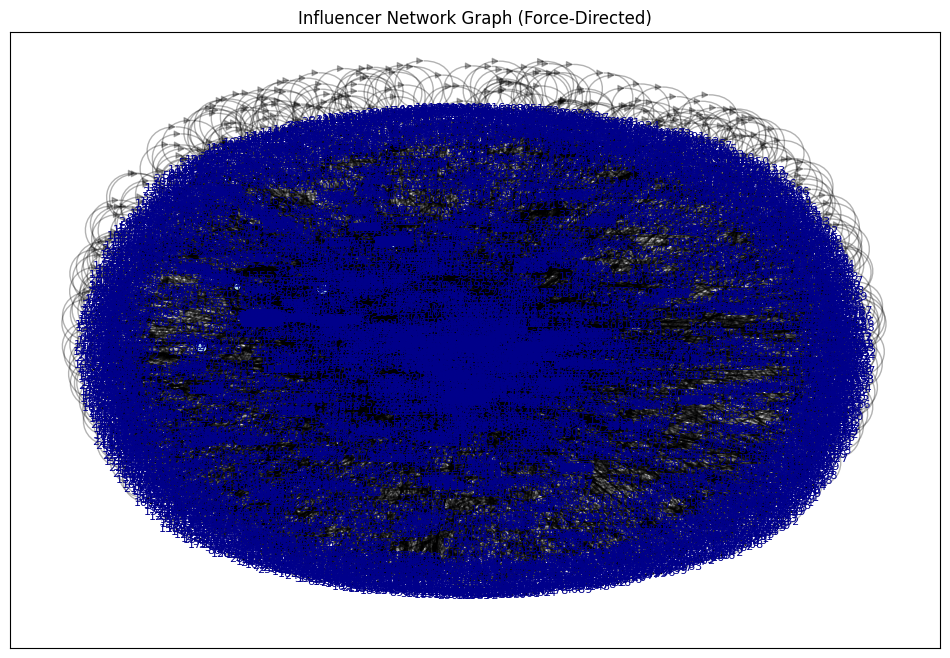

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add edges from DataFrame
for _, row in df.iterrows():
    G.add_edge(row["source"], row["target"])

# Compute PageRank for node sizes
pagerank_scores = nx.pagerank(G)
node_sizes = [pagerank_scores[node] * 5000 for node in G.nodes()]

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Force-directed layout

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="lightblue", edgecolors="black")
nx.draw_networkx_edges(G, pos, alpha=0.3, arrowstyle="-|>", arrowsize=10)
nx.draw_networkx_labels(G, pos, font_size=8, font_color="darkblue")

plt.title("Influencer Network Graph (Force-Directed)")
plt.show()

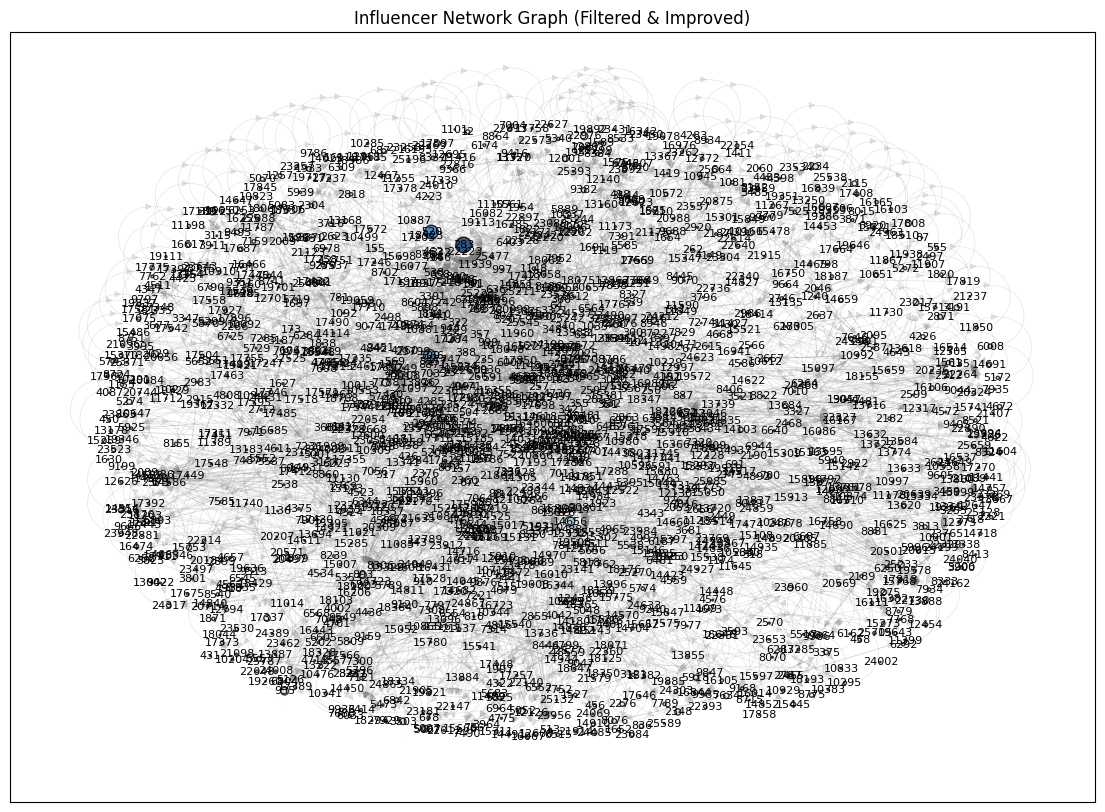

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add edges from DataFrame
for _, row in df.iterrows():
    G.add_edge(row["source"], row["target"])

# Remove low-degree nodes (optional: filter for key influencers)
degree_threshold = 5  # Change this threshold based on your data
G_filtered = G.subgraph([n for n, d in G.degree() if d >= degree_threshold])

# Compute PageRank for node sizes
pagerank_scores = nx.pagerank(G_filtered)
node_sizes = [pagerank_scores[node] * 5000 for node in G_filtered.nodes()]

# Compute node colors based on influence
node_color = [pagerank_scores[node] for node in G_filtered.nodes()]

# Draw the improved graph
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G_filtered, k=0.15, seed=42)  # Force-directed layout with better spacing

nx.draw_networkx_nodes(G_filtered, pos, node_size=node_sizes, node_color=node_color, cmap=plt.cm.Blues, alpha=0.8, edgecolors="black")
nx.draw_networkx_edges(G_filtered, pos, alpha=0.2, width=0.5, edge_color="gray")
nx.draw_networkx_labels(G_filtered, pos, font_size=8, font_color="black")

plt.title("Influencer Network Graph (Filtered & Improved)")
plt.show()

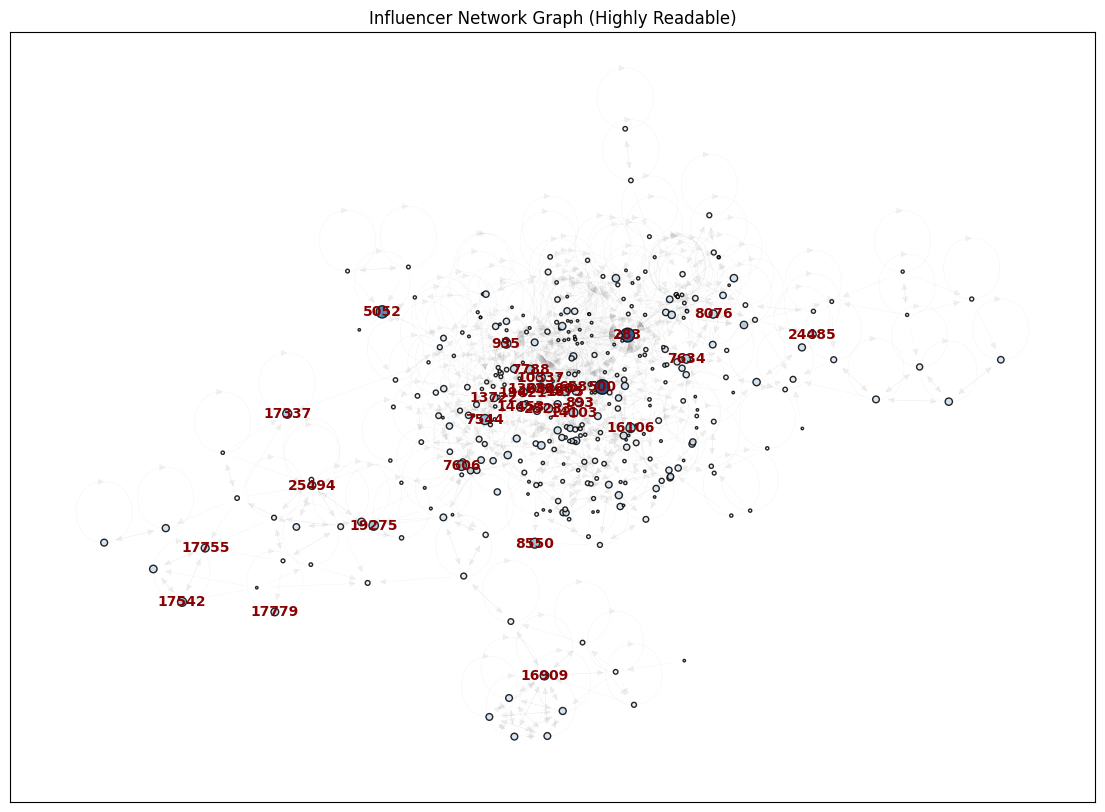

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Create a directed graph
G = nx.DiGraph()

# Add edges from DataFrame
for _, row in df.iterrows():
    G.add_edge(row["source"], row["target"])

# Remove nodes with low connections (change threshold as needed)
degree_threshold = 10  # Keep only well-connected influencers
G_filtered = G.subgraph([n for n, d in G.degree() if d >= degree_threshold])

# Compute PageRank for node importance
pagerank_scores = nx.pagerank(G_filtered)

# Log-scale node sizes to avoid huge differences
node_sizes = [np.log1p(pagerank_scores[node]) * 5000 for node in G_filtered.nodes()]

# Compute node colors based on influence (normalized)
node_color = [pagerank_scores[node] for node in G_filtered.nodes()]

# Use Kamada-Kawai layout (better for large graphs)
pos = nx.kamada_kawai_layout(G_filtered)

# Plot the improved graph
plt.figure(figsize=(14, 10))

# Draw nodes with PageRank-based coloring
nx.draw_networkx_nodes(G_filtered, pos, node_size=node_sizes, node_color=node_color, cmap=plt.cm.Blues, alpha=0.85, edgecolors="black")

# Draw fewer edges with transparency to reduce clutter
nx.draw_networkx_edges(G_filtered, pos, alpha=0.1, width=0.3, edge_color="gray")

# Draw influencer labels (only for top influencers)
top_influencers = sorted(pagerank_scores, key=pagerank_scores.get, reverse=True)[:30]
nx.draw_networkx_labels(G_filtered, pos, labels={n: str(n) for n in top_influencers}, font_size=10, font_color="darkred", font_weight="bold")

plt.title("Influencer Network Graph (Highly Readable)")
plt.show()

In [6]:
from networkx.algorithms.community import greedy_modularity_communities
# Step 3: Fetch Influencer Usernames
usernames_query = "SELECT influencer_id, username FROM influencers;"
influencer_map = pd.read_sql(usernames_query, engine).set_index("influencer_id")["username"].to_dict()
# Compute Mentions Received (in-degree) & Given (out-degree)
in_degree = dict(G_filtered.in_degree())
out_degree = dict(G_filtered.out_degree())

# Find influencer clusters using Louvain Community Detection
communities = list(greedy_modularity_communities(G_filtered))
community_map = {node: i for i, comm in enumerate(communities) for node in comm}

# Step 5: Convert IDs to Usernames & Create Insights DataFrame
influencer_insights = pd.DataFrame({
    "Influencer_ID": list(G_filtered.nodes()),
    "Username": [influencer_map.get(node, "Unknown") for node in G_filtered.nodes()],
    "PageRank": [pagerank_scores[node] for node in G_filtered.nodes()],
    "Mentions_Received": [in_degree[node] for node in G_filtered.nodes()],
    "Mentions_Given": [out_degree[node] for node in G_filtered.nodes()],
    "Community": [community_map[node] for node in G_filtered.nodes()]
})

# Step 6: Extract Key Insights

# 🔹 Top 10 Most Influential Influencers (by PageRank)
top_influencers = influencer_insights.sort_values(by="PageRank", ascending=False).head(10)

# 🔹 Top 10 Most Mentioned Influencers (by in-degree)
most_mentioned = influencer_insights.sort_values(by="Mentions_Received", ascending=False).head(10)

# 🔹 Top 10 Most Engaging Influencers (by out-degree)
most_engaging = influencer_insights.sort_values(by="Mentions_Given", ascending=False).head(10)

# 🔹 Largest Influencer Clusters
cluster_sizes = influencer_insights["Community"].value_counts().head(5)

# 🔹 Isolated Influencers (no interactions)
isolated_influencers = influencer_insights[(influencer_insights["Mentions_Received"] == 0) & 
                                           (influencer_insights["Mentions_Given"] == 0)]

# Step 7: Print Insights
print("🔹 Top 10 Most Influential Influencers (by PageRank):")
print(top_influencers[["Username", "PageRank"]], "\n")

print("🔹 Top 10 Most Mentioned Influencers:")
print(most_mentioned[["Username", "Mentions_Received"]], "\n")

print("🔹 Top 10 Most Engaging Influencers (giving the most mentions):")
print(most_engaging[["Username", "Mentions_Given"]], "\n")

print("🔹 Largest Influencer Clusters:")
print(cluster_sizes, "\n")

print(f"🔹 Number of Isolated Influencers: {len(isolated_influencers)}")

🔹 Top 10 Most Influential Influencers (by PageRank):
                Username  PageRank
86           iluvsarahii  0.021915
52   urbandecaycosmetics  0.020117
181        laurenlefevre  0.015472
270         lydiaemillen  0.010375
67            lynzyandco  0.010175
282          aligordon89  0.009889
143          a_ontheroad  0.009364
322          valeairoldi  0.008854
173             drbrandt  0.008794
179                  cb2  0.008334 

🔹 Top 10 Most Mentioned Influencers:
                Username  Mentions_Received
52   urbandecaycosmetics                 45
16           desiperkins                 18
305                 katy                 17
116       kristenxleanne                 15
56           thefeedfeed                 15
158        patrickstarrr                 13
86           iluvsarahii                 12
269       bohemian_heart                 10
331           alissayoga                 10
89       nicoleguerriero                 10 

🔹 Top 10 Most Engaging Influencers (g

C:\Users\madhu\AppData\Local\Temp\ipykernel_35028\1671552387.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", num_communities)


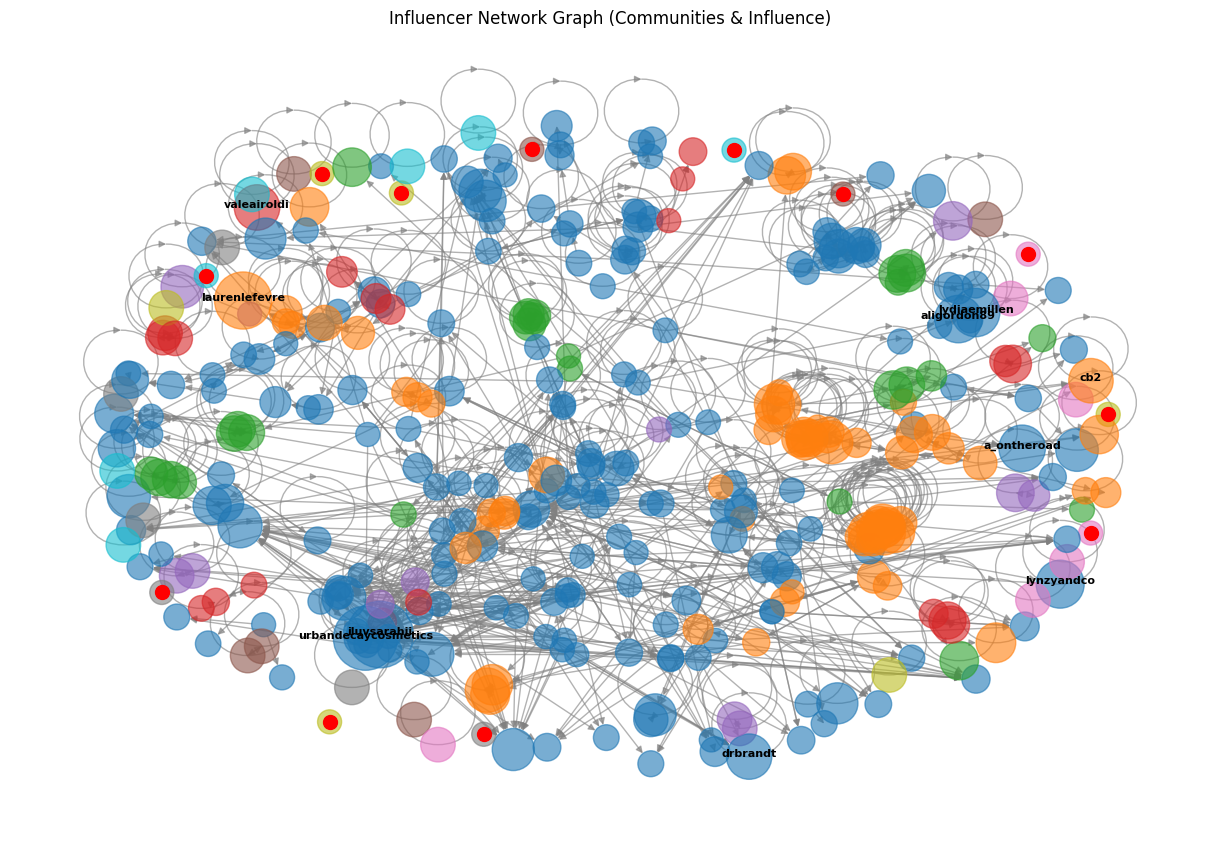

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Create a color map for communities
num_communities = len(set(community_map.values()))
colors = plt.cm.get_cmap("tab10", num_communities)
node_colors = [colors(community_map[node] % num_communities) for node in G_filtered.nodes()]

# Scale node sizes based on PageRank scores
pagerank_scaled = np.array([pagerank_scores[node] for node in G_filtered.nodes()])
node_sizes = 300 + (pagerank_scaled - pagerank_scaled.min()) / (pagerank_scaled.max() - pagerank_scaled.min()) * 2000

# Create the network graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_filtered, seed=42)
nx.draw(G_filtered, pos, with_labels=False, node_size=node_sizes, node_color=node_colors, edge_color='gray', alpha=0.6)

# Label top influencers (PageRank)
for _, row in top_influencers.iterrows():
    node = row["Influencer_ID"]
    plt.text(pos[node][0], pos[node][1], row["Username"], fontsize=8, fontweight='bold', ha='center', color='black')

# Highlight isolated influencers
isolated_nodes = isolated_influencers["Influencer_ID"].tolist()
nx.draw_networkx_nodes(G_filtered, pos, nodelist=isolated_nodes, node_color='red', node_size=100, label='Isolated')

plt.title("Influencer Network Graph (Communities & Influence)")
plt.show()